In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Reviews.csv',nrows=1000)

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df = df[['Text','Score']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1000 non-null   object
 1   Score   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
df['Score'].value_counts()

Score
5    642
4    138
1     98
3     75
2     47
Name: count, dtype: int64

This is an inbalanced dataset and need to handle using either classwights or resampling technique while modeling

Clean the text data

In [9]:
def get_lemmatization_text(sentence):
    import nltk
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from spellchecker import SpellChecker
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

    english_spellchecker = SpellChecker(language='en')
    lemmatizer = WordNetLemmatizer()
    words_lst = word_tokenize(sentence)
    unkown_words = english_spellchecker.unknown(words_lst)
    corrected_words_lst = []
    for word in words_lst:
        if word not in stopwords.words('english') and len(word)>2:
            if word in unkown_words:
                correct_word = english_spellchecker.correction(word)
                if correct_word is not None:
                    corrected_words_lst.append(lemmatizer.lemmatize(correct_word))
            else:
                corrected_words_lst.append(lemmatizer.lemmatize(word))
    return " ".join(corrected_words_lst)

def get_preprocessed_text(sentence):
    import regex as re

    sentence = re.sub(r'\W+',' ',sentence)
    sentence = re.sub(r'\d+',' ',sentence)
    sentence = re.sub(r'_',' ',sentence)
    sentence = re.sub(r'\s+',' ',sentence)
    sentence = sentence.lower().strip()
    setence = get_lemmatization_text(sentence)

    return setence, len(setence.split())

In [10]:
df['preprocessed_text'] = df['Text'].apply(get_preprocessed_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell

,Text,Score,preprocessed_text
0,I have bought several of the Vitality canned d...,5,(bought several vitality canned dog food produ...
1,Product arrived labeled as Jumbo Salted Peanut...,1,(product arrived labeled jumbo salted peanut p...
2,This is a confection that has been around a fe...,4,(confection around century light pillowy citru...
3,If you are looking for the secret ingredient i...,2,(looking secret ingredient believe found got a...
4,Great taffy at a great price. There was a wid...,5,(great taffy great price wide assortment yummy...


In [11]:
df['preprocessed_text'][0]

('bought several vitality canned dog food product found good quality product look like stew processed meat smell better abrader finicky appreciates product better',
 23)

In [12]:
df[['preprocessed_text','length_of_the_sentence']] = df['preprocessed_text'].astype(str).str.split(',',expand=True)
df.head()

,Text,Score,preprocessed_text,length_of_the_sentence
0,I have bought several of the Vitality canned d...,5,('bought several vitality canned dog food prod...,23)
1,Product arrived labeled as Jumbo Salted Peanut...,1,('product arrived labeled jumbo salted peanut ...,18)
2,This is a confection that has been around a fe...,4,('confection around century light pillowy citr...,39)
3,If you are looking for the secret ingredient i...,2,('looking secret ingredient believe found got ...,17)
4,Great taffy at a great price. There was a wid...,5,('great taffy great price wide assortment yumm...,13)


In [13]:
df['preprocessed_text'] = df['preprocessed_text'].replace(r'\W+',' ',regex=True)
df['length_of_the_sentence'] = df['length_of_the_sentence'].replace(r'\W+',' ',regex=True)
df.head()


,Text,Score,preprocessed_text,length_of_the_sentence
0,I have bought several of the Vitality canned d...,5,bought several vitality canned dog food produ...,23
1,Product arrived labeled as Jumbo Salted Peanut...,1,product arrived labeled jumbo salted peanut p...,18
2,This is a confection that has been around a fe...,4,confection around century light pillowy citru...,39
3,If you are looking for the secret ingredient i...,2,looking secret ingredient believe found got a...,17
4,Great taffy at a great price. There was a wid...,5,great taffy great price wide assortment yummy...,13


Unique word frequency in the text

In [14]:
df_unique = df['preprocessed_text'].str.split(expand=True).stack().value_counts()
df_unique.head()

chip      659
like      441
flavor    398
taste     346
good      326
Name: count, dtype: int64

In [18]:
df_unique.to_csv('./unique_word_frequency.csv',index=True)

Low informative Word

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df['preprocessed_text'])

TfidfVectorizer()

In [20]:
unique_word_tfidf_dict = dict(zip(vectorizer.get_feature_names_out(),vectorizer.idf_))
pd.DataFrame(unique_word_tfidf_dict.items(),columns=['Unique_word','tfidf_value']).to_csv('./word_tfidf.csv',index=False)

Find Max length of the text corpus

<Axes: xlabel='length_of_the_sentence', ylabel='Count'>

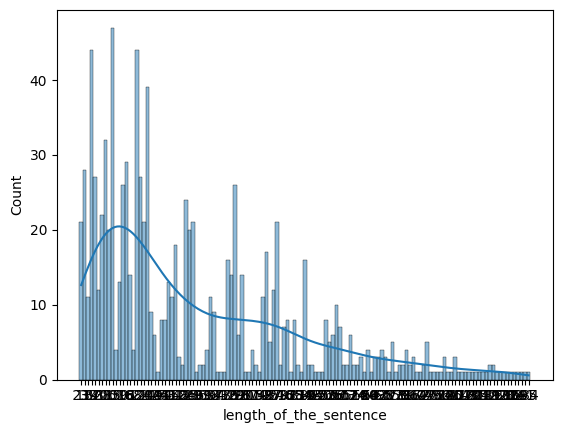

In [21]:
sns.histplot(data=df,x='length_of_the_sentence',kde=True)

In [22]:
df['length_of_the_sentence'].astype(int).describe()

count    1000.00000
mean       35.55900
std        34.50329
min         4.00000
25%        15.00000
50%        25.00000
75%        43.00000
max       460.00000
Name: length_of_the_sentence, dtype: float64

In [23]:
print(f'median value of length of the sentences: {np.median(df.length_of_the_sentence.astype(int))}')

median value of length of the sentences: 25.0


In [24]:

median_value = np.median(df.length_of_the_sentence.astype(int))
std_value = np.std(df.length_of_the_sentence.astype(int))
median_value, std_value

(25.0, 34.486033680317604)

In [25]:
max_length1 = int(median_value+2*std_value)
max_length2 = int(median_value+3*std_value)
max_length3 = int(median_value+4*std_value)
max_length1, max_length2, max_length3

(93, 128, 162)